# Results Visualizer
This notebook contains a set of visualizations and graphs of the processed results, based on the different hypotheses and conducted experiments. The format is as follows:
- Import of required packages and initialization of parameters that are used throughout the notebook
- A section is dedicated for each of the hypotheses of the thesis that contains more information about the hypothesis, the experiments and the respective results, along with visualizations and graphs.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
# matplotlib params
plt.rcParams.update({
    'font.size': 18,
    'lines.linewidth': 3,
    'axes.titlesize': 18,
    'figure.titlesize': 'x-large'
})
# save figures flag
save_figs = False

## PART 0 - Metadata
In the output directory of each experiment, there is `metadata.csv` file that stores the configuration of the individual runs for each experiment:
- **dataset_name**: the name of the dataset
- **dataset_iter**: specific train/test split of the dataset used
- **search_type**: `'random', 'ue' or 'smac'`
- **num_classifiers**: list of PyOD classifiers used
- **validation_strategy**: `stratified` or `balanced`
- **validation_size**: `20`, `50`, `100`, `200` or `400`
- **total_budget**: total budget in seconds
- **per_run_budget**: budget per individual run in seconds

From these values, the aggregated experiment parameters are calculated and passed later on to the plotting function for each hypothesis.

In [2]:
# Output directories
results_dirname = '../results/results'
results_path = os.path.join(Path.cwd(), results_dirname)
results_processed_path = os.path.join(results_path, 'processed')
# Import metadata
metadata_filepath = os.path.join(results_path, 'metadata.csv')
metadata_df = pd.read_csv(metadata_filepath)
# Remove individual ue (random search) runs
metadata_df = metadata_df[metadata_df['total_budget'] != 30]
# Extract experiment parameters
total_budget = metadata_df.total_budget[0]
dataset_list = list(metadata_df.dataset_name.unique())
validation_strategy_list = list(metadata_df.validation_strategy.unique())
validation_size_list = list(metadata_df.validation_size.unique())
# Default width and height for plots
if len(dataset_list) > 3:
    w0 = 4
    h0 = 4
else:
    w0 = 5
    h0=5
# Print the parameters
print('Total budget:', total_budget)
print('Dataset list:', dataset_list)
print('Validation strategy list:', validation_strategy_list)
print('Validation size list:', validation_size_list)

Total budget: 600
Dataset list: ['ALOI', 'Annthyroid', 'Cardiotocography', 'KDDCup99', 'SpamBase', 'Waveform']
Validation strategy list: ['stratified', 'balanced']
Validation size list: [20, 50, 100, 200]


## PART 1 - Performance Summary
### 1.1 - Performance Summary per Dataset
This section parses the processed results for each dataset and prints the best optimization and test scores along with the parameters that achieved them:
 - Search algorithm
 - Validation set split strategy
 - Validation set size

In [3]:
# Performance per dataset
for dataset in dataset_list:
    best_opt_score = 0.0
    best_test_score = 0.0
    best_opt_params = None
    best_test_params = None
    for filename in os.listdir(results_processed_path):
        if dataset in filename:
            # import performance data as DataFrame
            df = pd.read_csv(
                os.path.join(
                    results_processed_path, filename),
            )
            # optimization score
            if df['single_best_optimization_score'].iloc[-1] > best_opt_score:
                best_opt_score = df['single_best_optimization_score'].iloc[-1]
                best_opt_params = filename.split('.')[0].split('_')[1:]
            # test score
            if df['single_best_test_score'].iloc[-1] > best_test_score:
                best_test_score = df['single_best_test_score'].iloc[-1]
                best_test_params = filename.split('.')[0].split('_')[1:]
    print(dataset)
    print('  Opt\t ({}, {})'.format(best_opt_score, best_opt_params))
    print('  Test\t ({}, {})\n'.format(best_test_score, best_test_params))
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

ALOI
  Opt	 (0.9578947368421054, ['random', 'stratified', '20'])
  Test	 (0.7147302051888678, ['random', 'balanced', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Annthyroid
  Opt	 (0.9444444444444444, ['random', 'stratified', '20'])
  Test	 (0.7243458646616542, ['ue', 'balanced', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Cardiotocography
  Opt	 (0.890625, ['ue', 'stratified', '20'])
  Test	 (0.7670566757945398, ['ue', 'balanced', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
KDDCup99
  Opt	 (1.0, ['ue', 'stratified', '50'])
  Test	 (0.9899866666666666, ['ue', 'balanced', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
SpamBase
  Opt	 (0.8109999999999999, ['smac', 'balanced', '20'])
  Test	 (0.6950094183242916, ['ue', 'stratified', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Waveform
  Opt	 (0.9947368421052633, ['ue', 'stratified', '20'])
  Test	 (0.797035885

### 1.2 - Performance Summary per Dataset-Search Algorithm
This section parses the processed results for each dataset and and search algorithm and prints the best optimization and test scores along with the parameters that achieved them:
 - Validation set split strategy
 - Validation set size
 
Furthermore, it computes statistical tests for comparing the 3 search algorithms:
 - Friedmann test
 - Nemenyi post-hoc test

In [4]:
# Performance per (dataset, search algorithm) tuples
search_algorithm_list = ['random', 'ue', 'smac']
np_matrix = np.zeros((len(dataset_list), 3)) # number of search algorithms = 3
for i, dataset in enumerate(dataset_list):
    print(dataset)
    for j, search in enumerate(search_algorithm_list):
        best_opt_score = 0.0
        best_test_score = 0.0
        best_opt_params = None
        best_test_params = None
        for filename in os.listdir(results_processed_path):
            if dataset in filename and search in filename:
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path, filename),
                )
                # optimization score
                if df['single_best_optimization_score'].iloc[-1] > best_opt_score:
                    best_opt_score = df['single_best_optimization_score'].iloc[-1]
                    best_opt_params = filename.split('.')[0].split('_')[2:]
                # test score
                if df['single_best_test_score'].iloc[-1] > best_test_score:
                    best_test_score = df['single_best_test_score'].iloc[-1]
                    best_test_params = filename.split('.')[0].split('_')[2:]
        np_matrix[i][j] = best_test_score
        print('  ' + search)
        print('\tOpt\t ({}, {})'.format(best_opt_score, best_opt_params))
        print('\tTest\t ({}, {})\n'.format(best_test_score, best_test_params))
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
# construct pd matrix
matrix = pd.DataFrame(
    np_matrix, 
    columns=search_algorithm_list, 
    index=dataset_list
)
matrix

ALOI
  random
	Opt	 (0.9578947368421054, ['stratified', '20'])
	Test	 (0.7147302051888678, ['balanced', '200'])

  ue
	Opt	 (0.9105263157894736, ['stratified', '20'])
	Test	 (0.7032469982798987, ['balanced', '200'])

  smac
	Opt	 (0.9157894736842104, ['stratified', '20'])
	Test	 (0.7090472389823155, ['balanced', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Annthyroid
  random
	Opt	 (0.9444444444444444, ['stratified', '20'])
	Test	 (0.7095069491911599, ['balanced', '200'])

  ue
	Opt	 (0.913888888888889, ['stratified', '20'])
	Test	 (0.7243458646616542, ['balanced', '200'])

  smac
	Opt	 (0.9277777777777778, ['stratified', '20'])
	Test	 (0.6959302802460698, ['balanced', '100'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Cardiotocography
  random
	Opt	 (0.8640625, ['stratified', '20'])
	Test	 (0.7615135673388099, ['stratified', '200'])

  ue
	Opt	 (0.890625, ['stratified', '20'])
	Test	 (0.7670566757945398, ['balanced', '200'])

 

,random,ue,smac
ALOI,0.714730,0.703247,0.709047
Annthyroid,0.709507,0.724346,0.695930
Cardiotocography,0.761514,0.767057,0.764509
KDDCup99,0.987588,0.989987,0.987953
SpamBase,0.692316,0.695009,0.692204
Waveform,0.751842,0.797036,0.769632


### 1.3 - Statistical Comparison of Search Algorithms
This section conducts a non-parametric Friedman test to assess the significance of difference in average performance of N different search algorithms on M datasets.

In [5]:
# Statistical comparison of search algorithms
# Add ML-stats directory to sys
import os, sys
p = os.path.abspath('../ML-stats')
sys.path.insert(1, p)
# Imports
from src.classifier_comparisons import BlockDesign
from src.multiple_classifiers import friedman_test
from src.multiple_classifiers import nemenyi_friedman_test
# Block design
block_design = BlockDesign(matrix, threshold=0.01, precision=2, higher_is_better=True)
# Friedman test
test_results = friedman_test(block_design, alpha=0.05)
test_results

Number of compared methods: 3
Number of datasets: 6
Number of compared methods: 3
Number of datasets: 6


,alpha,critical value,test statistic,p value,significant? (test stat > crit value)
Friedman test,0.05,5.991465,0.583333,0.747018,False
Iman Davenport,0.05,4.102821,0.255474,0.779454,False


## PART 2 - Evaluation of Hypotheses
### 2.1 - H1: Guided vs. unguided search

**Statement**: *Guided search algorithms such as SMAC are expected to perform better than unguided search algorithms such as Random Search and Uniform Exploration.*

**Comments**:
- The comparison should be done per dataset.
- The comparison should be done for a specified validation strategy (e.g. stratified) and size (e.g. a percentage 30% of the original training set).

### Generic plotting functions
The plotting functions used in the hypotheses sections. were made generic so the generated plots can depend only on the input arguments:
- **output_performance_path**: path to the `performance` directory
- **dataset_list**: list of datasets used in the experiment
- **total_budget**: total budget in seconds
- **validation_strategy_list**: `['stratified', 'balanced']`
- **validation_size_list**: `[20, 50, 100, 200, 400]`
- **eval_type**: `opt` or `test`
- **plot_color_list**: used for consistent coloring

In [6]:
# Plotting function for H1
def plot_h1_results(
    results_processed_path, # str
    dataset_list, # list(str)
    total_budget, # int
    validation_strategy, # int
    validation_size, # int
    eval_type, # str
    color_list # list(str)
):
    # Figure
    width = w0 * len(dataset_list)
    height = h0 * len(dataset_list)
    fig = plt.figure(
        figsize=(width, height)) # grid dimensions
    fig.subplots_adjust(
        wspace=0.4, hspace=0.3) # space between plots
    fig.suptitle(
        'Performance on {} set for {} validation set of size {}'\
        .format(
            eval_type,
            validation_strategy,
            validation_size),
        y=0.93
    )
    # Plots
    for i, dataset in enumerate(dataset_list):
        for filename in os.listdir(results_processed_path):
            if dataset in filename \
            and validation_strategy in filename \
            and str(validation_size)+'.' in filename:
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path, filename),
                )
                # x-axis (time)
                x = df.Timestamp
                # score based on eval_type
                if eval_type == 'opt':
                    y = df.single_best_optimization_score
                elif eval_type == 'test':
                    y = df.single_best_test_score
                # plot
                label = filename.split('_')[1]
                ax = plt.subplot(3, 3, i + 1)
                ax.set_ylim([0.5, 1.])
                ax.set_xlabel('seconds')
                ax.set_ylabel('score')
                ax.plot(x, y, label=label, color=color_list[label])
                ax.grid()
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(
                    *sorted(zip(labels, handles), key=lambda t: t[0]))
                ax.legend(handles, labels, loc='lower right')
                plt.title(dataset)
                if save_figs:
                    plt.savefig('{}_{}_{}_{}.png'.format(
                        eval_type,
                        total_budget,
                        validation_strategy,
                        validation_size
                    ))

In [7]:
# Parameters for H1
validation_size_h1 = 200
color_list_h1 = {
    'ue': 'orange',
    'random': 'green',
    'smac': 'royalblue',
}

#### 2.1.1 - Performance for stratified validation sets
The below graphs display the optimization performance, i.e. the performance on the validation set used in Bayesian Optimization, per dataset, for the case of `stratified` validation sets.

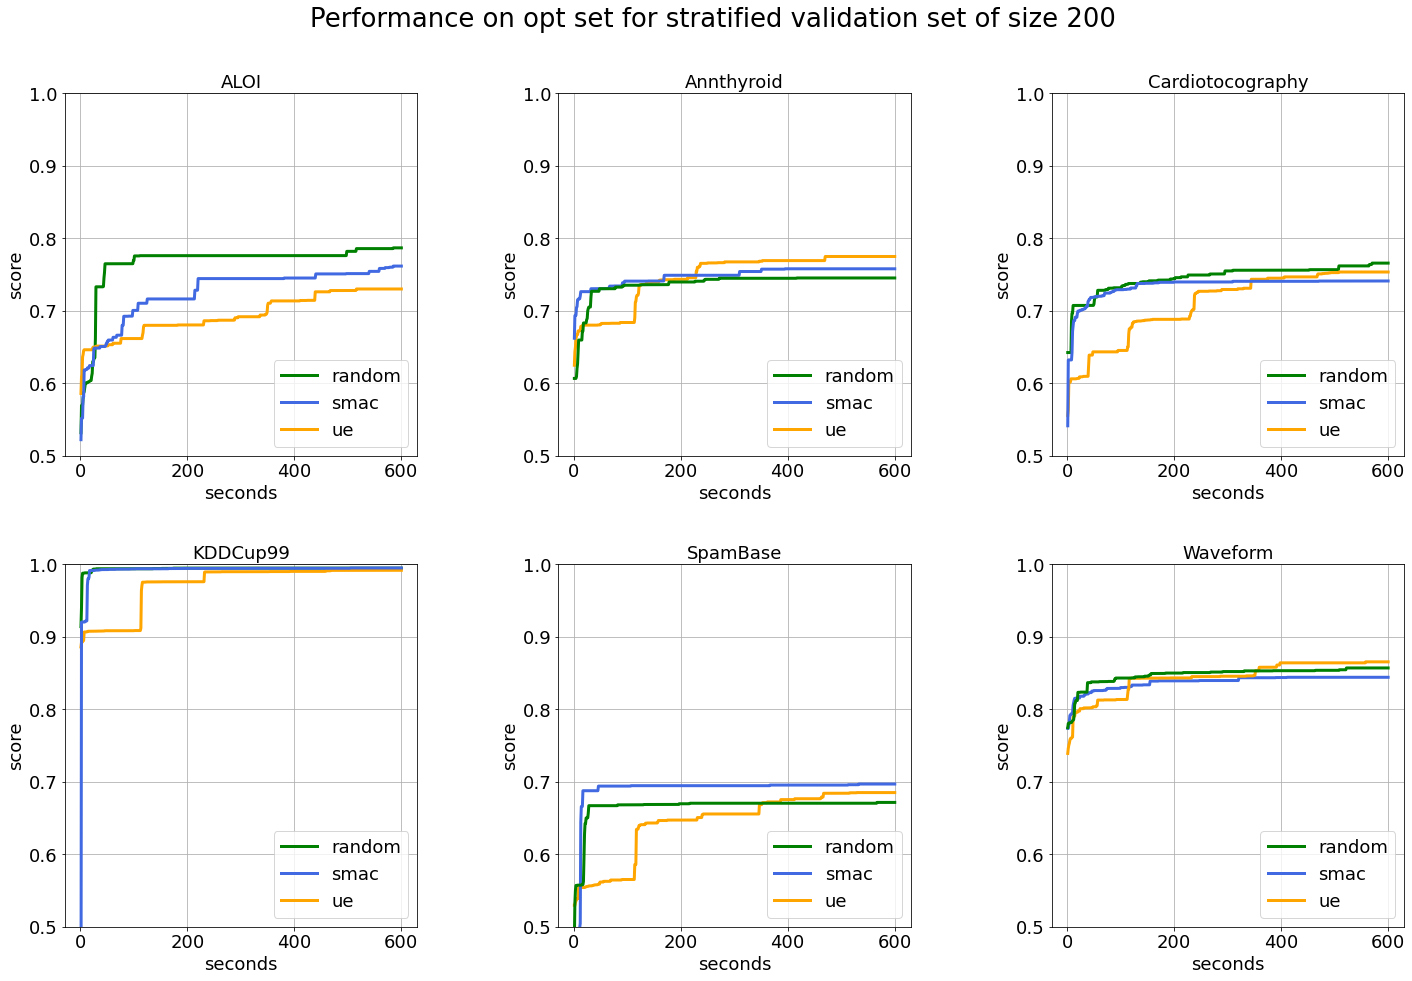

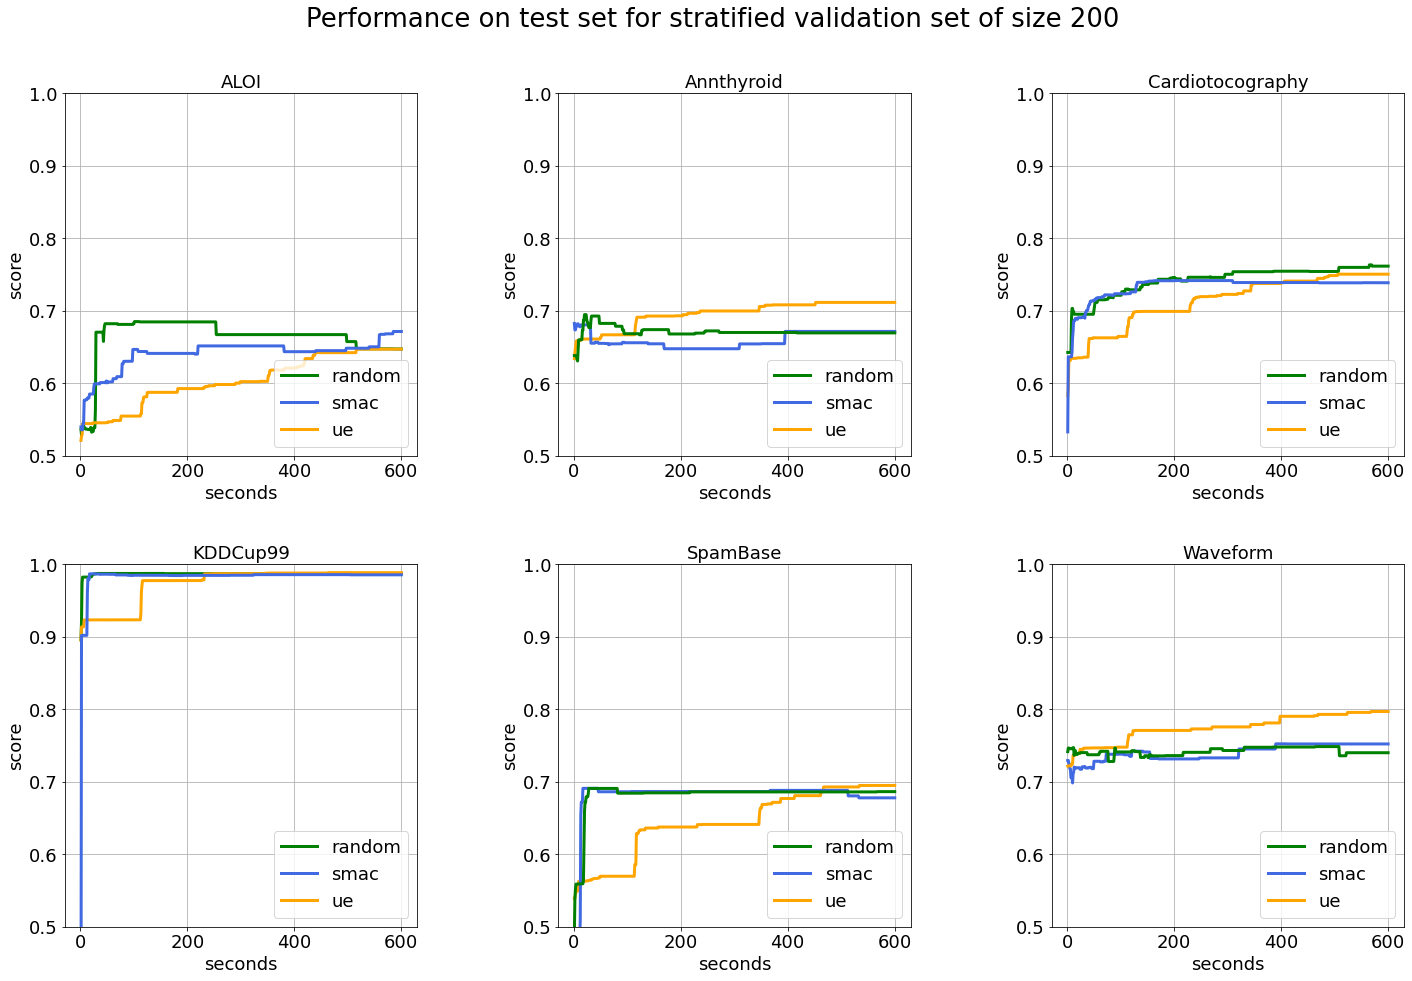

In [8]:
# Parameters for H1.A
validation_strategy_h11 = 'stratified'
# Plot optimization performance
plot_h1_results(
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_h11,
    validation_size_h1,
    'opt',
    color_list_h1
)
# Plot test set performance
plot_h1_results(
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_h11,
    validation_size_h1,
    'test',
    color_list_h1
)

#### 2.1.2 - Performance for balanced validation sets
The below graphs display the test set performance per dataset

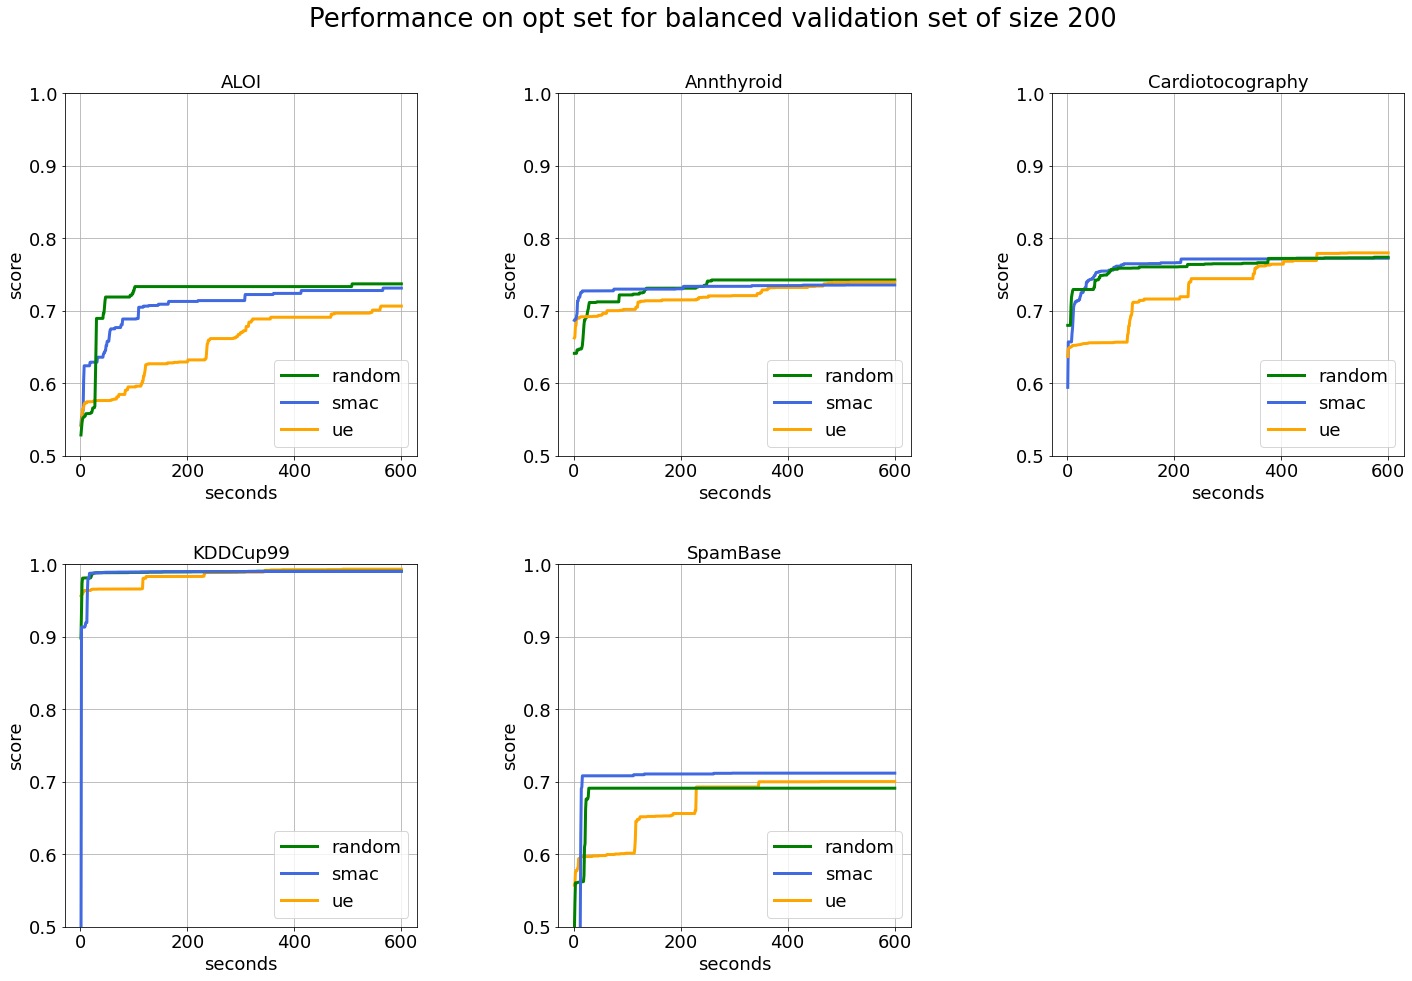

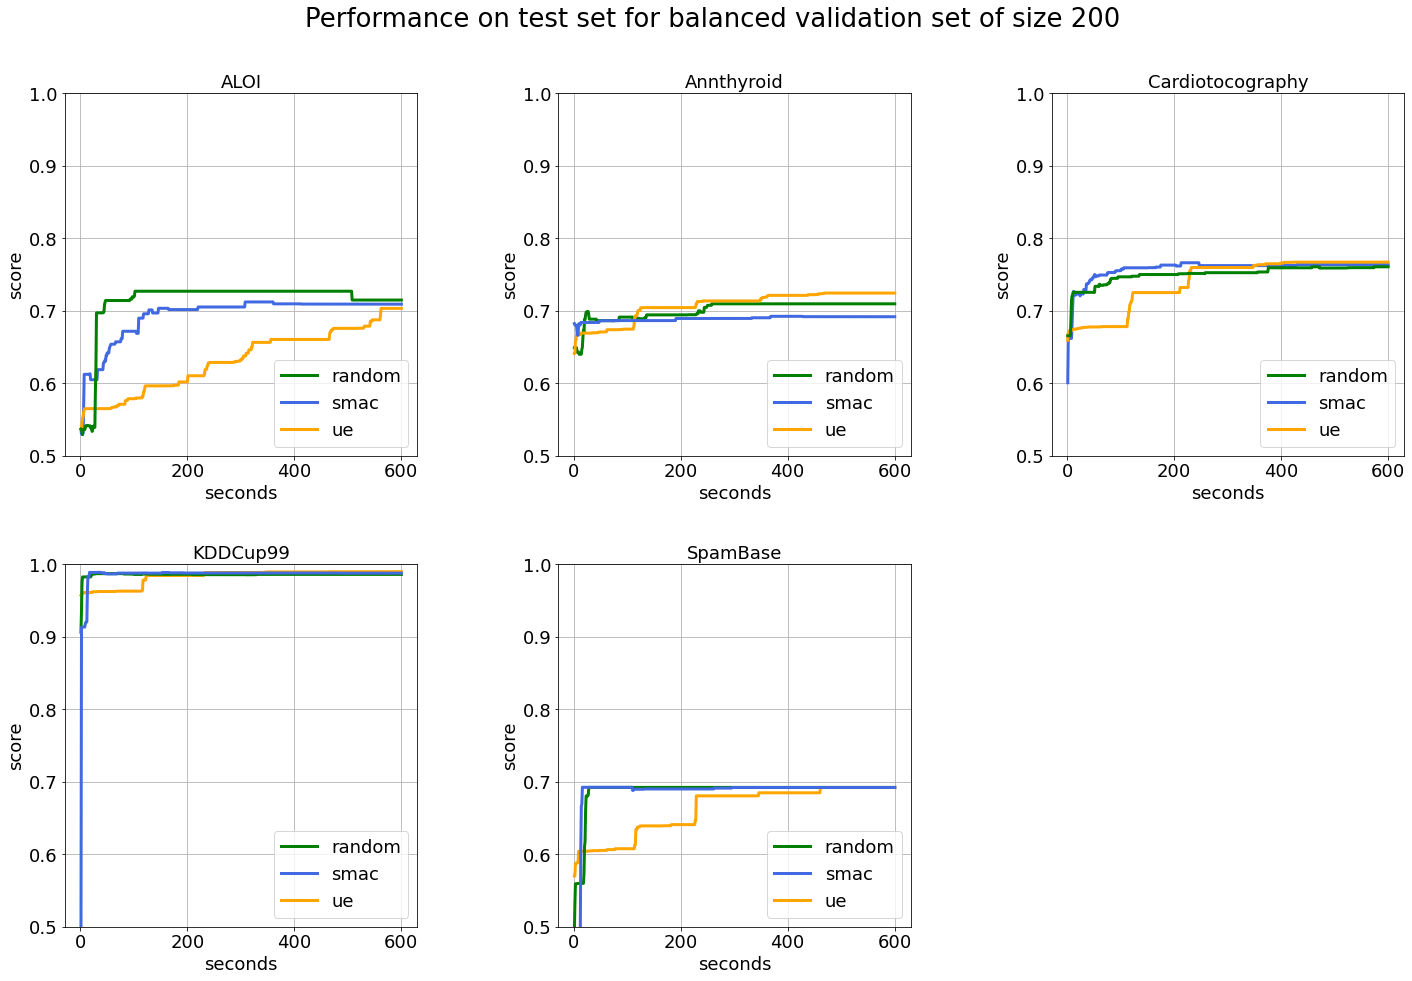

In [9]:
# Parameters for H1.B
validation_strategy_h12 = 'balanced'
# Plot optimization performance
plot_h1_results(
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_h12,
    validation_size_h1,
    'opt',
    color_list_h1
)
# Plot test set performance
plot_h1_results(
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_h12,
    validation_size_h1,
    'test',
    color_list_h1
)

### 2.2 - H2: Stratified vs. balanced validation sets

**Statement**: *Stratified validation sets are expected to have better performance compared to balanced validation sets.*

**Comments**:
- The expectation of better performance when using stratified validation sets stems from the fact that stratified-sampled validation sets better represent the actual data distribution.
- The comparison should be done per dataset.
- The comparison should be done per search algorithm (uniform exploration, random search, smac)
- The comparison should be done for a specified validation set size (e.g. 30% of the original training set).

In [10]:
# Plotting function for H2
def plot_h2_results(
    results_processed_path, # str
    dataset_list, # list(str)
    search_algorithm, # str
    total_budget, # int
    validation_size, # int
    eval_type, # str
    color_list # list(str)
):
    # Figure
    width = w0 * len(dataset_list)
    height = h0 * len(dataset_list)
    fig = plt.figure(
        figsize=(width, height)) # grid dimensions
    fig.subplots_adjust(
        wspace=0.4, hspace=0.3) # space between plots
    fig.suptitle(
        'Performance on {} set for {} search and validation set of size {}'\
        .format(
            eval_type,
            search_algorithm,
            validation_size),
        y=0.93
    )
    # Plots
    for i, dataset in enumerate(dataset_list):
        for filename in os.listdir(results_processed_path):
            if dataset in filename and \
            search_algorithm in filename and \
            str(validation_size)+'.' in filename:
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path, filename)
                )
                # x-axis (time)
                x = df.Timestamp
                # score based on eval_type
                if eval_type == 'opt':
                    y = df.single_best_optimization_score
                elif eval_type == 'test':
                    y = df.single_best_test_score
                # plot
                label = filename.split('_')[2]
                ax = plt.subplot(3, 3, i + 1)
                ax.set_ylim([0.5, 1.])
                ax.set_xlabel('seconds')
                ax.set_ylabel('score')
                ax.plot(x, y, label=label, color=color_list[label])
                ax.grid()
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(
                    *sorted(zip(labels, handles), key=lambda t: t[0]))
                ax.legend(handles, labels, loc='lower right')
                plt.title(dataset)
                if save_figs:
                    plt.savefig('{}_{}_{}_{}.png'.format(
                        eval_type,
                        total_budget,
                        search_algorithm,
                        validation_size
                    ))

In [11]:
# Parameters for H2
validation_size_h2 = 100
color_list_h2 = {
    'stratified': 'orange',
    'balanced': 'green',
}

#### 2.2.1 - SMAC Search
The below graphs display the test set performance per dataset for the SMAC search

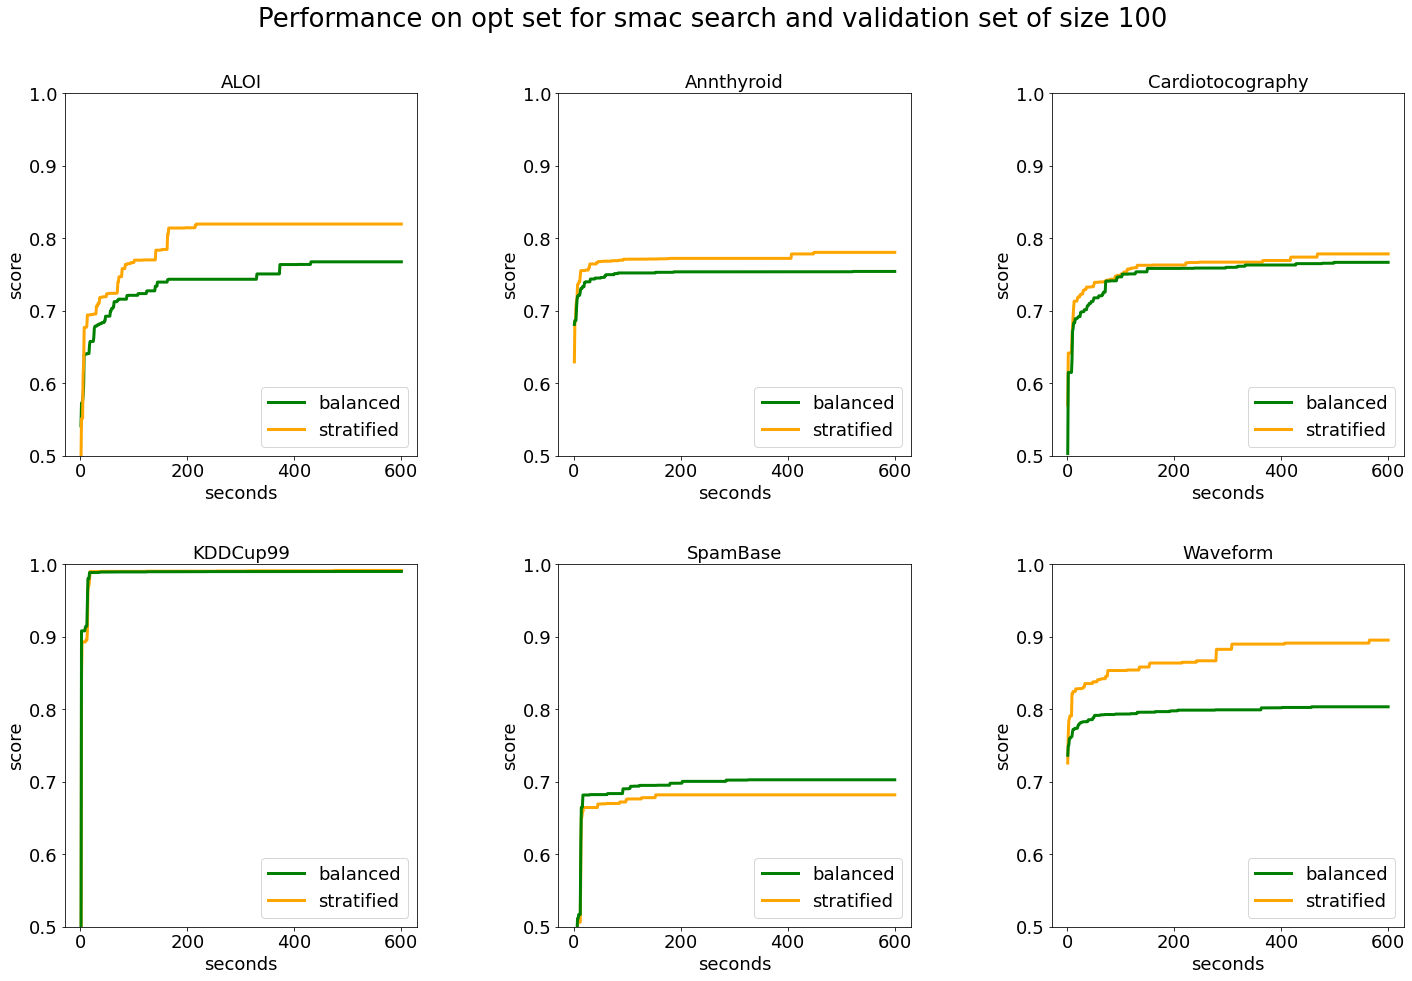

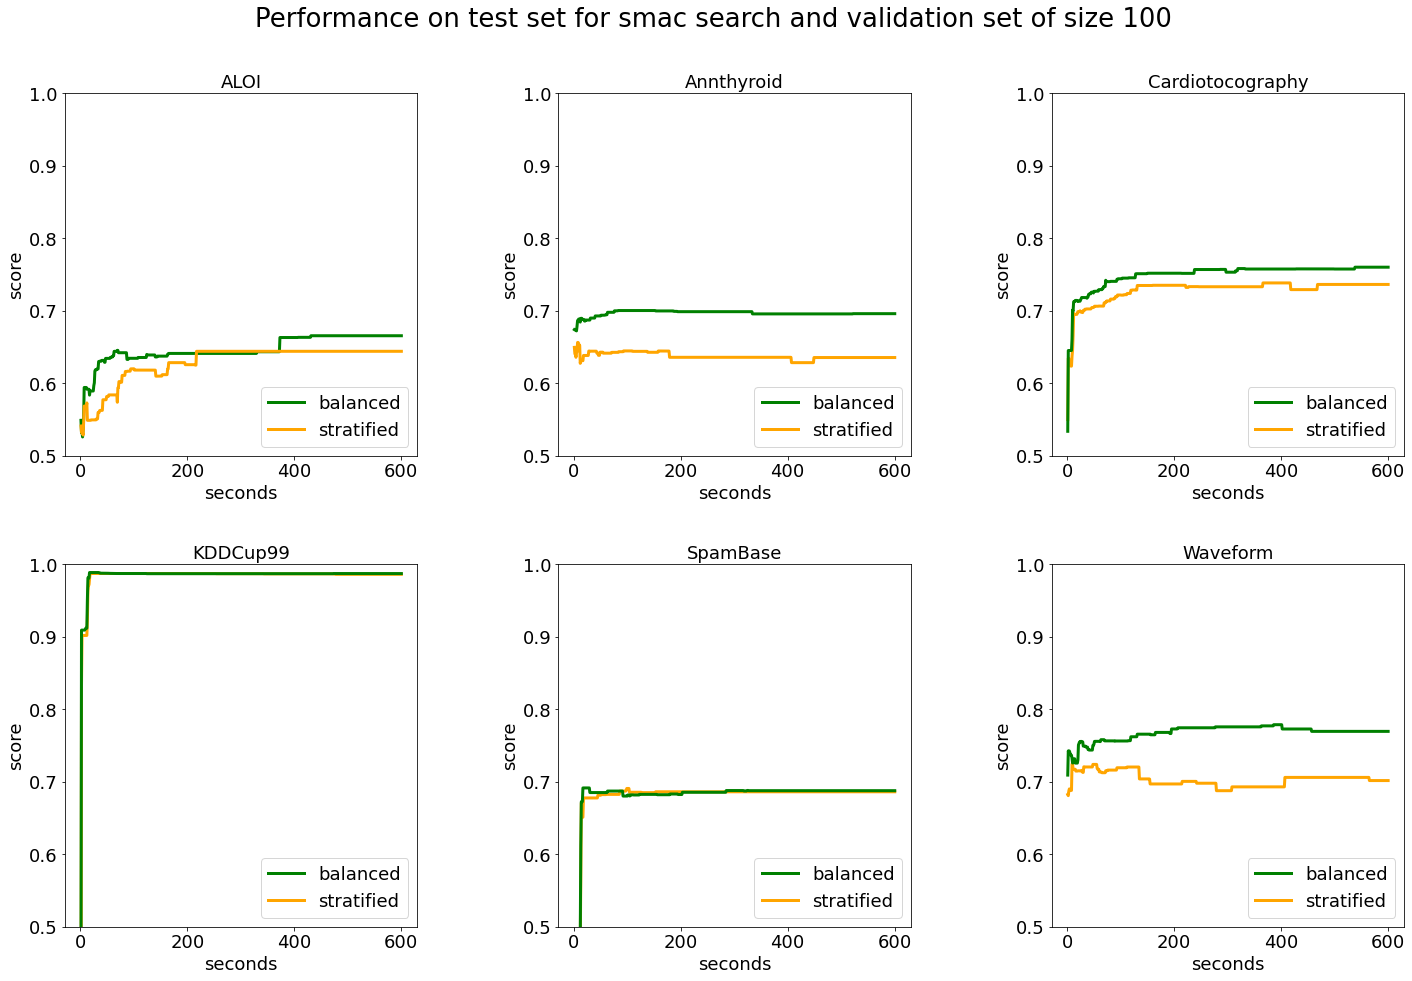

In [12]:
# Parameters for H2.1
search_algorithm_h21 = 'smac'
# Plot optimization performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h21,
    total_budget,
    validation_size_h2,
    'opt',
    color_list_h2
)
# Plot test set performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h21,
    total_budget,
    validation_size_h2,
    'test',
    color_list_h2
)

#### 2.2.2 - Random Search
The below graphs display the test set performance per dataset for *Random Search*

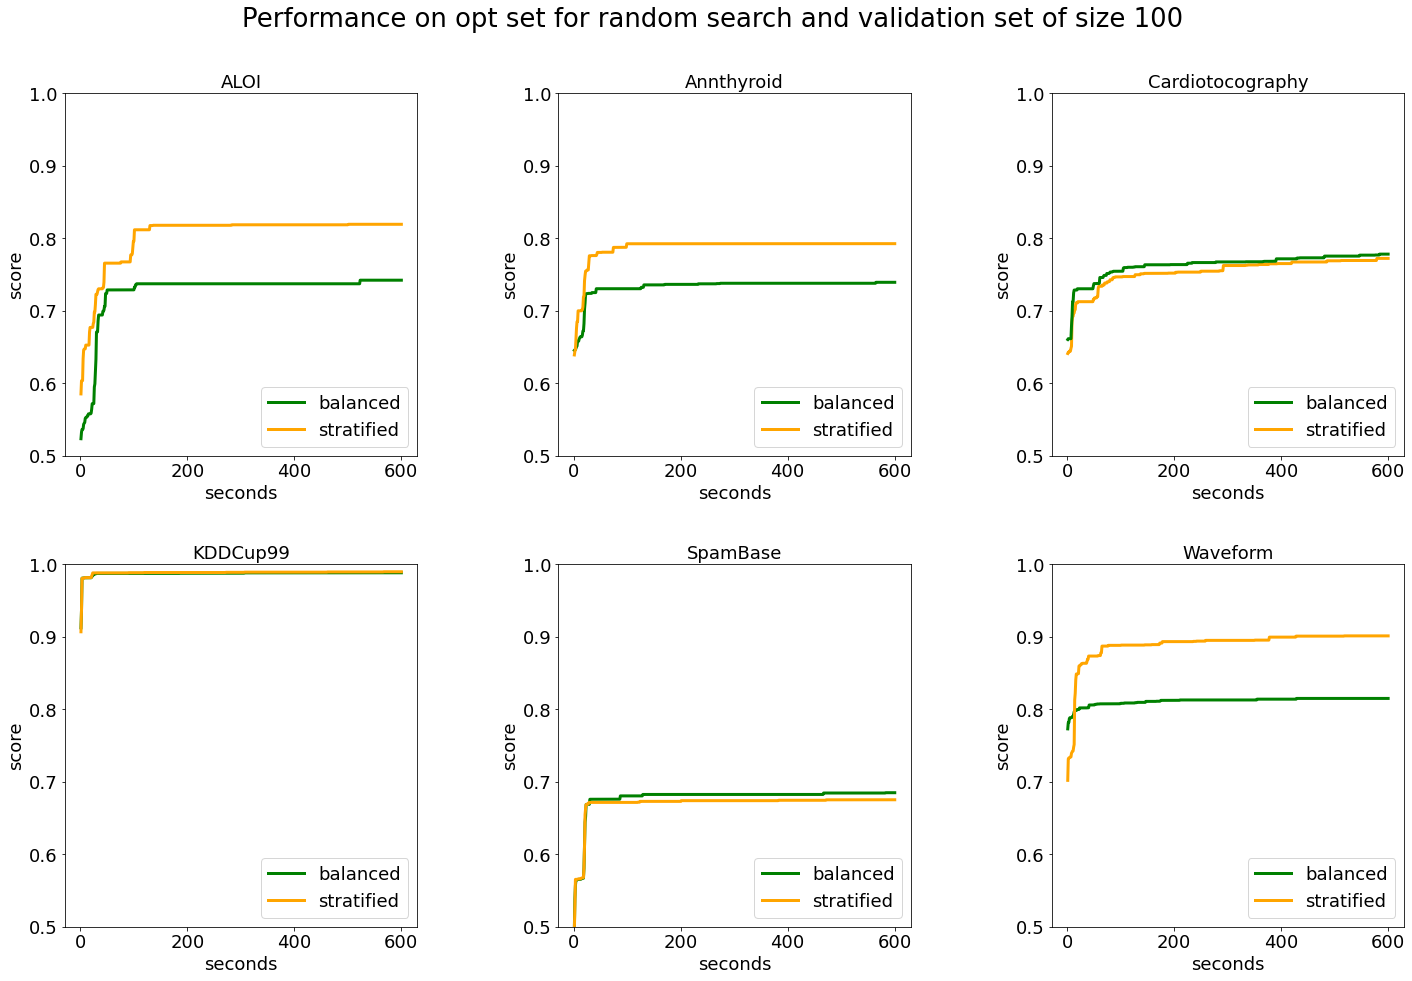

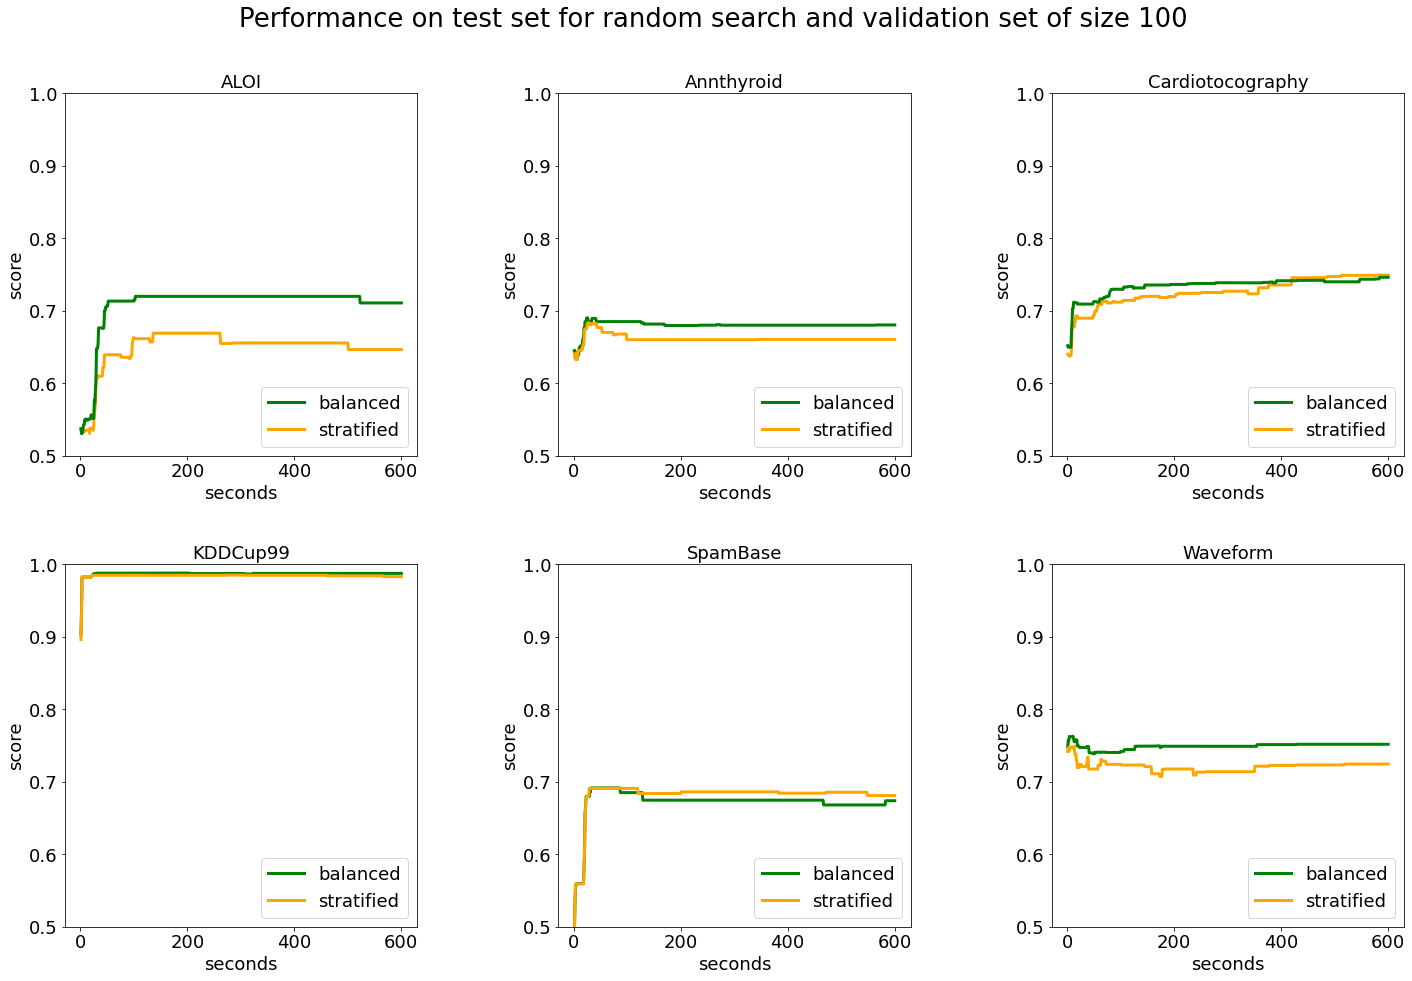

In [13]:
# Parameters for H2.2
search_algorithm_h22 = 'random'
# Plot optimization performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h22,
    total_budget,
    validation_size_h2,
    'opt',
    color_list_h2
)
# Plot test set performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h22,
    total_budget,
    validation_size_h2,
    'test',
    color_list_h2
)

#### 2.2.3 - Uniform Exploration Search
The below graphs display the test set performance per dataset for the *Uniform Exploration Search*

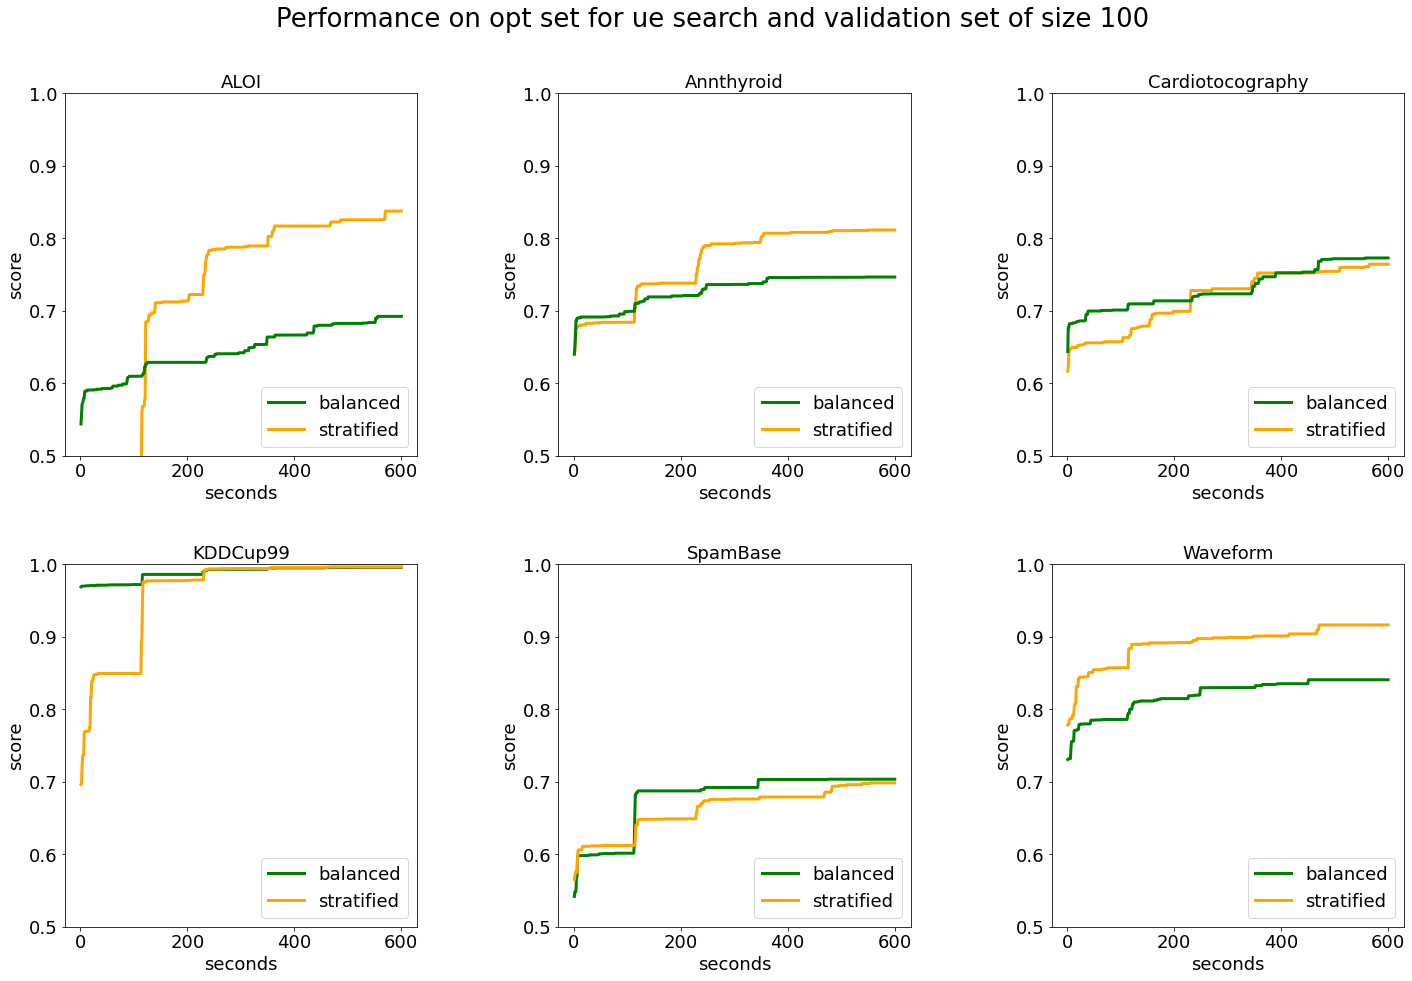

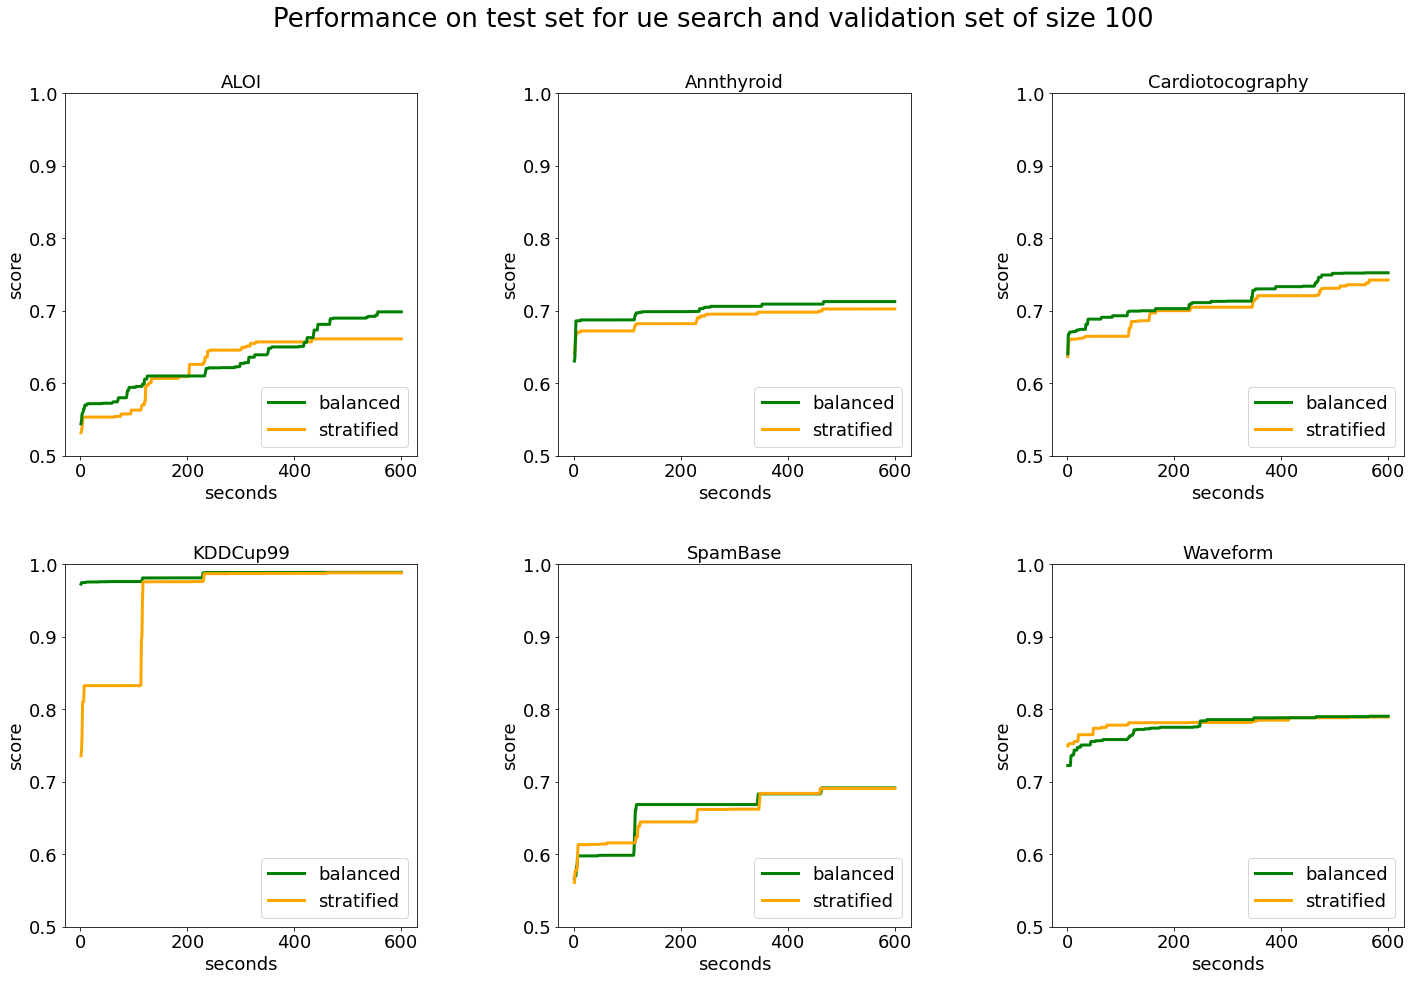

In [14]:
# Parameters for H2.3
search_algorithm_h23 = 'ue'
# Plot optimization performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h23,
    total_budget,
    validation_size_h2,
    'opt',
    color_list_h2
)
# Plot test set performance
plot_h2_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h23,
    total_budget,
    validation_size_h2,
    'test',
    color_list_h2
)

### 2.3 - H3: Larger vs. smaller validation sets

**Statement**: *Larger validation sets are expected to have better performance compared to smaller validation sets.*

**Comments**:
- Validation set sizes to compare: 20, 50, 100, 200
- Comparison should be done per dataset
- Comparison should be done per search algorithm

In [15]:
# Plotting function for H3
def plot_h3_results(
    results_processed_path, # str
    dataset_list, # list(str)
    search_algorithm, # str
    total_budget, # int
    validation_strategy, # str
    validation_size_list, # list(int)
    eval_type, # str
    color_list # list(str) 
):
    # Figure
    width = w0 * len(dataset_list)
    height = h0 * len(dataset_list)
    fig = plt.figure(
        figsize=(width, height)) # grid dimensions
    fig.subplots_adjust(
        wspace=0.4, hspace=0.3) # space between plots
    fig.suptitle(
        'Performance on {} set for {} search and {} validation set'\
        .format(
            eval_type,
            search_algorithm,
            validation_strategy),
        y=0.93
    )
    # Plots
    for i, dataset in enumerate(dataset_list):
        for filename in os.listdir(results_processed_path):
            if (dataset in filename and \
                search_algorithm in filename and \
                validation_strategy in filename \
                and any(str(size) in filename for size in validation_size_list)):
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path,
                        filename
                    )
                )
                # x-axis (seconds)
                x = df.Timestamp
                # score based on eval_type
                if eval_type == 'opt':
                    y = df.single_best_optimization_score
                elif eval_type == 'test':
                    y = df.single_best_test_score
                # plot
                label = int(filename.split('_')[3].split('.')[0])
                ax = plt.subplot(3, 3, i + 1)
                ax.set_ylim([0.2, 1.])
                ax.set_xlabel('seconds')
                ax.set_ylabel('score')
                ax.plot(x, y, label=label, color=color_list[label])
                ax.grid()
                handles, labels = ax.get_legend_handles_labels()
                labels = [int(l) for l in labels] # convert to integer for sorting
                labels, handles = zip(
                *sorted(zip(labels, handles), key=lambda t: t[0]))
                ax.legend(handles, labels, loc='lower right')
                plt.title(dataset)
                if save_figs:
                    plt.savefig('{}_{}_{}_{}.png'.format(
                        eval_type,
                        total_budget,
                        search_algorithm,
                        validation_strategy
                    ))

In [16]:
# Parameters for H3
validation_strategy_h3 = 'stratified'
color_list_h3 = {
    20: 'red',
    50: 'orange',
    100: 'green',
    200: 'royalblue',
}

#### 2.3.1 - SMAC Search
The below graphs display the test set performance per dataset for the **SMAC Search**

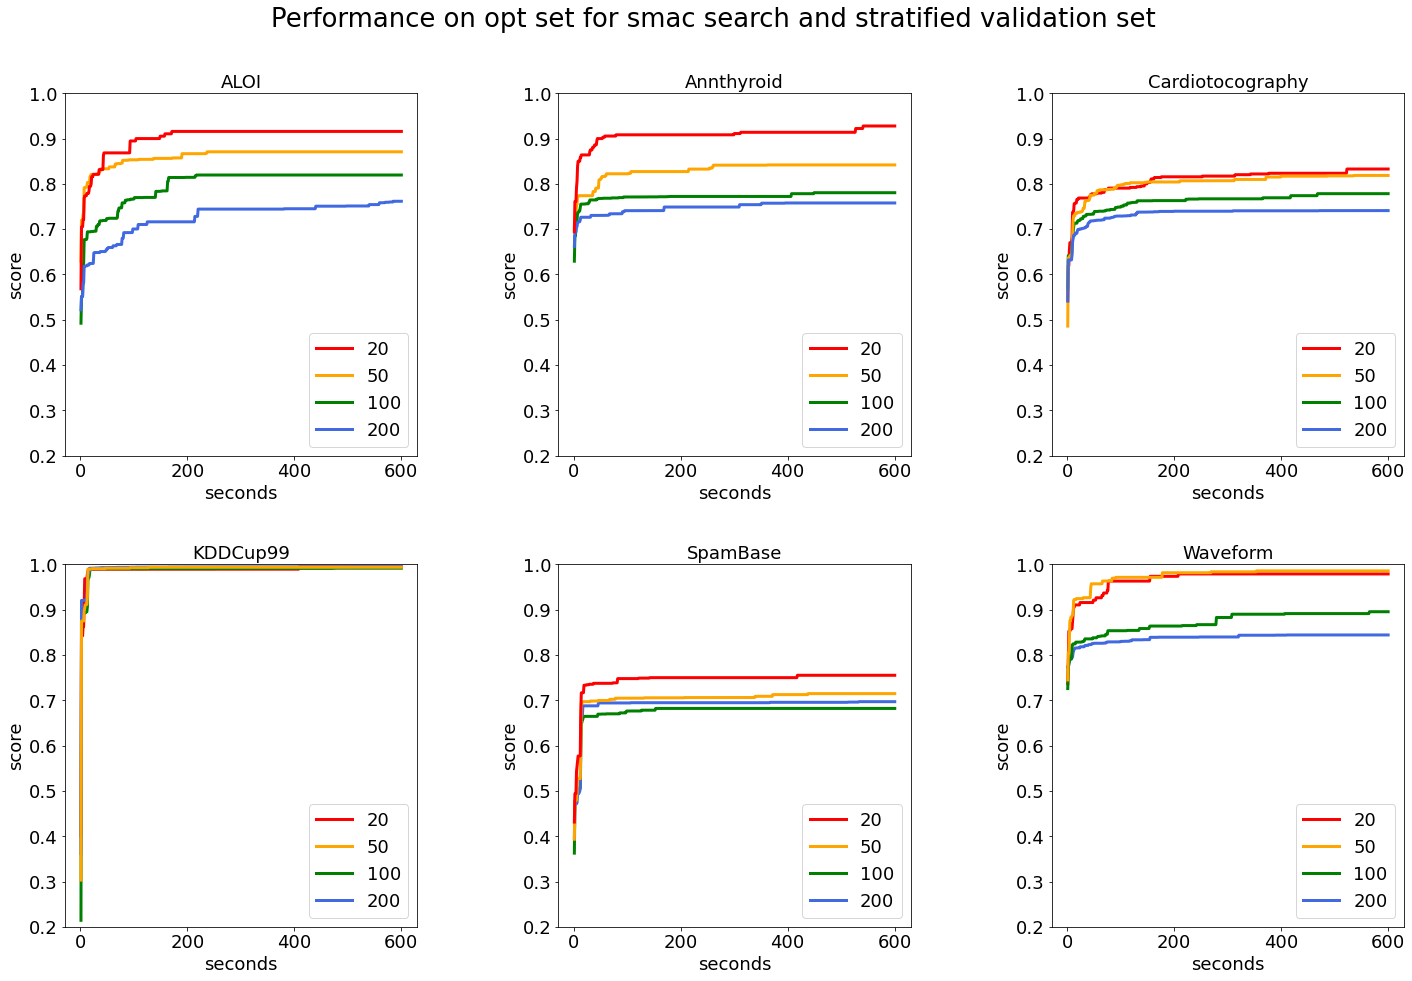

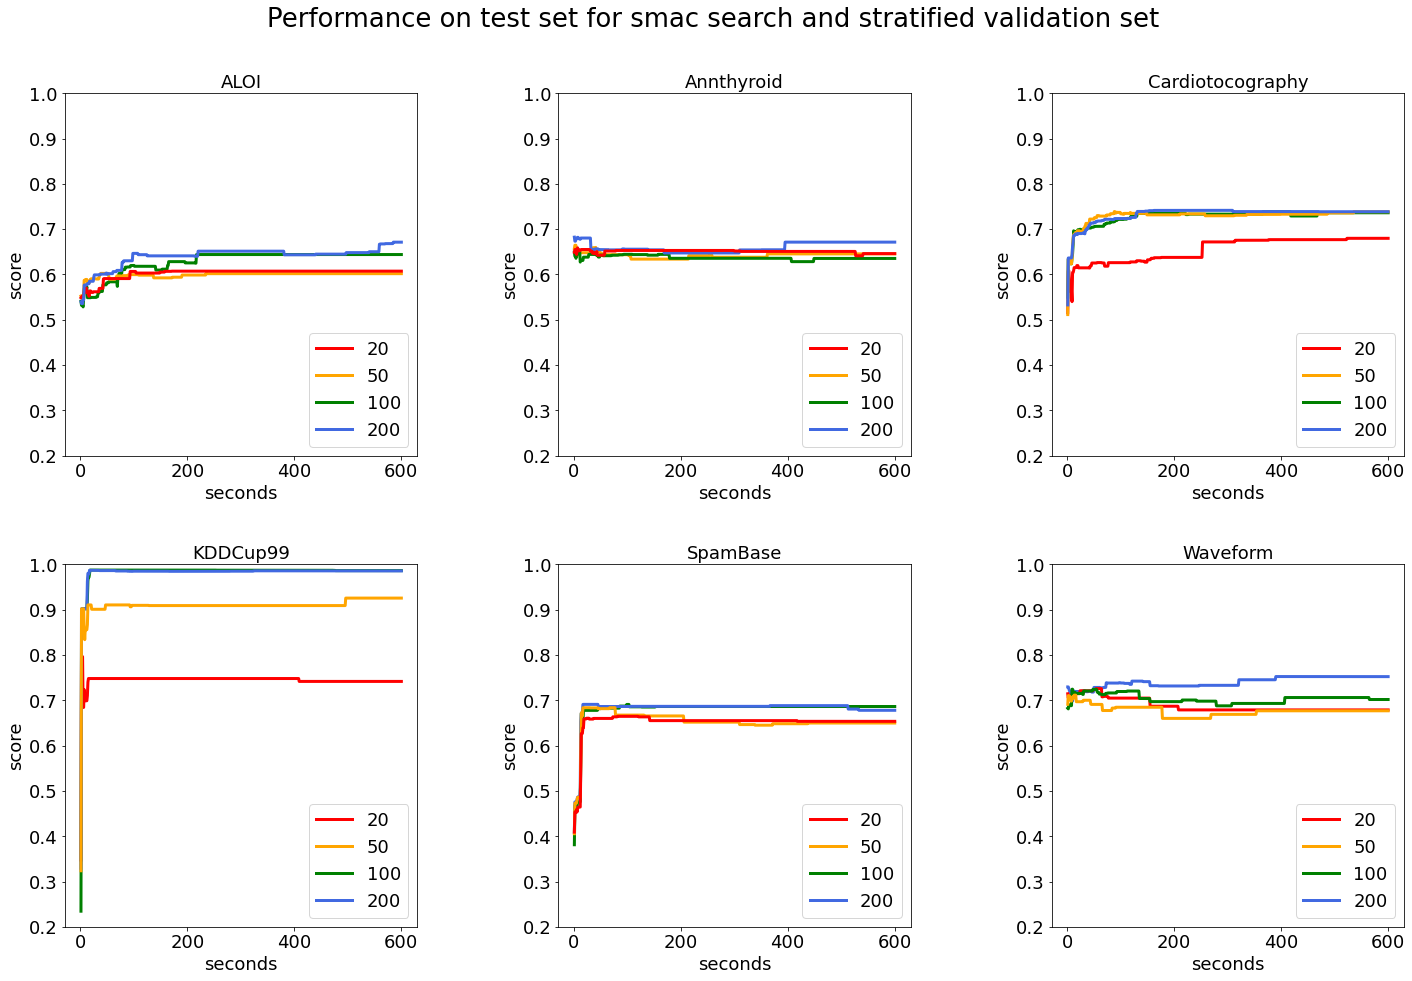

In [17]:
# Parameters for H3.1
search_algorithm_h31 = 'smac'
# Plot optimization performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h31,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    'opt',
    color_list_h3
)
# Plot test set performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h31,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    'test',
    color_list_h3
)

#### 2.3.2 - Random Search
The below graphs display the test set performance per dataset for **Random Search**

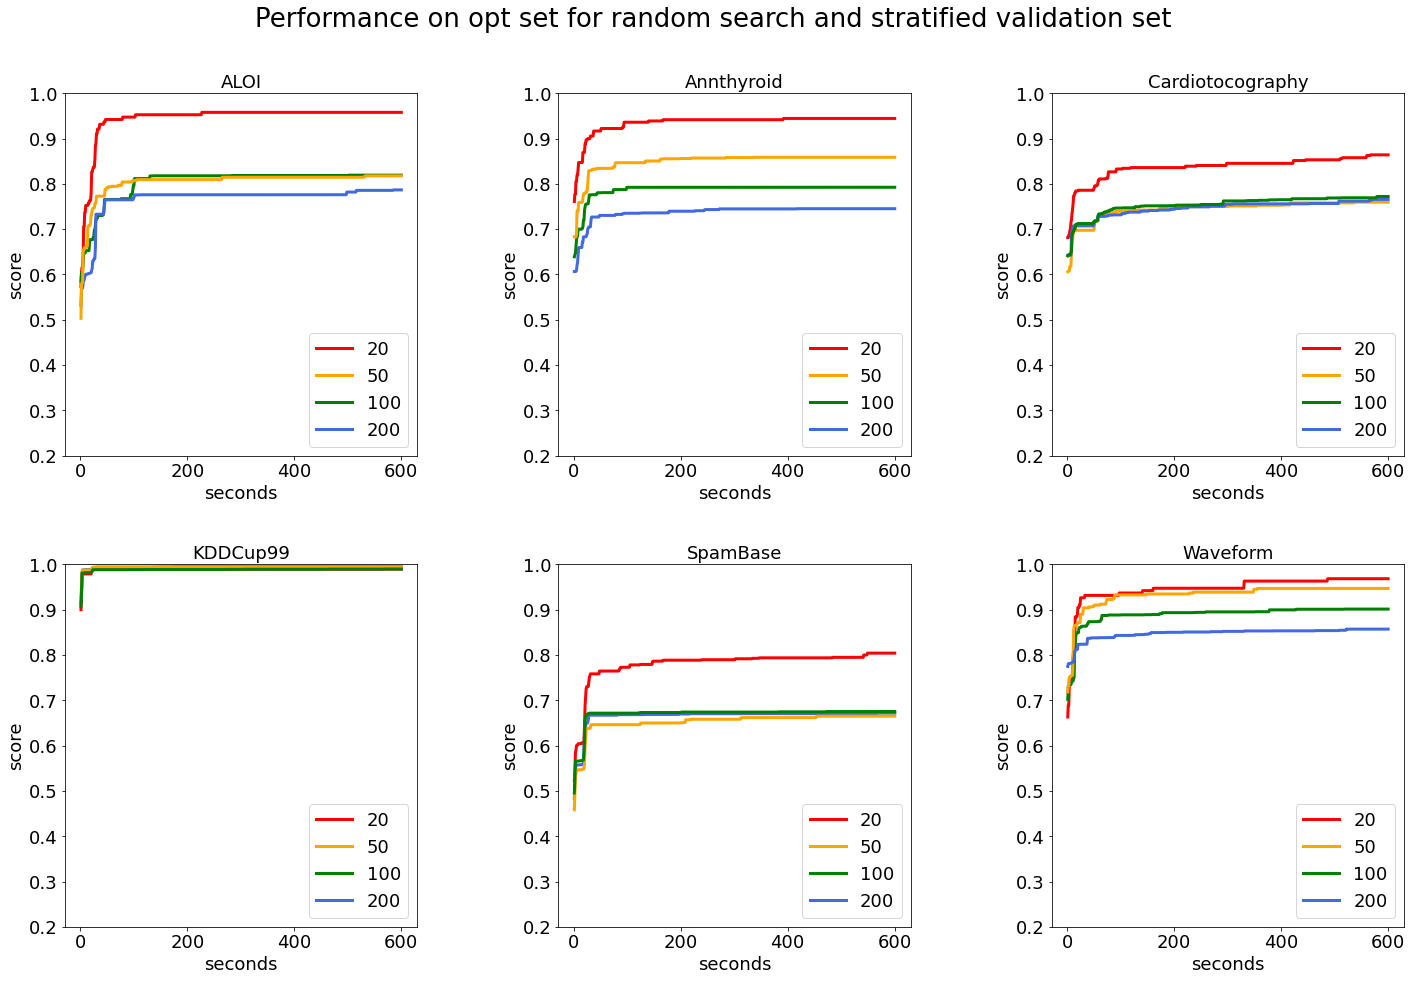

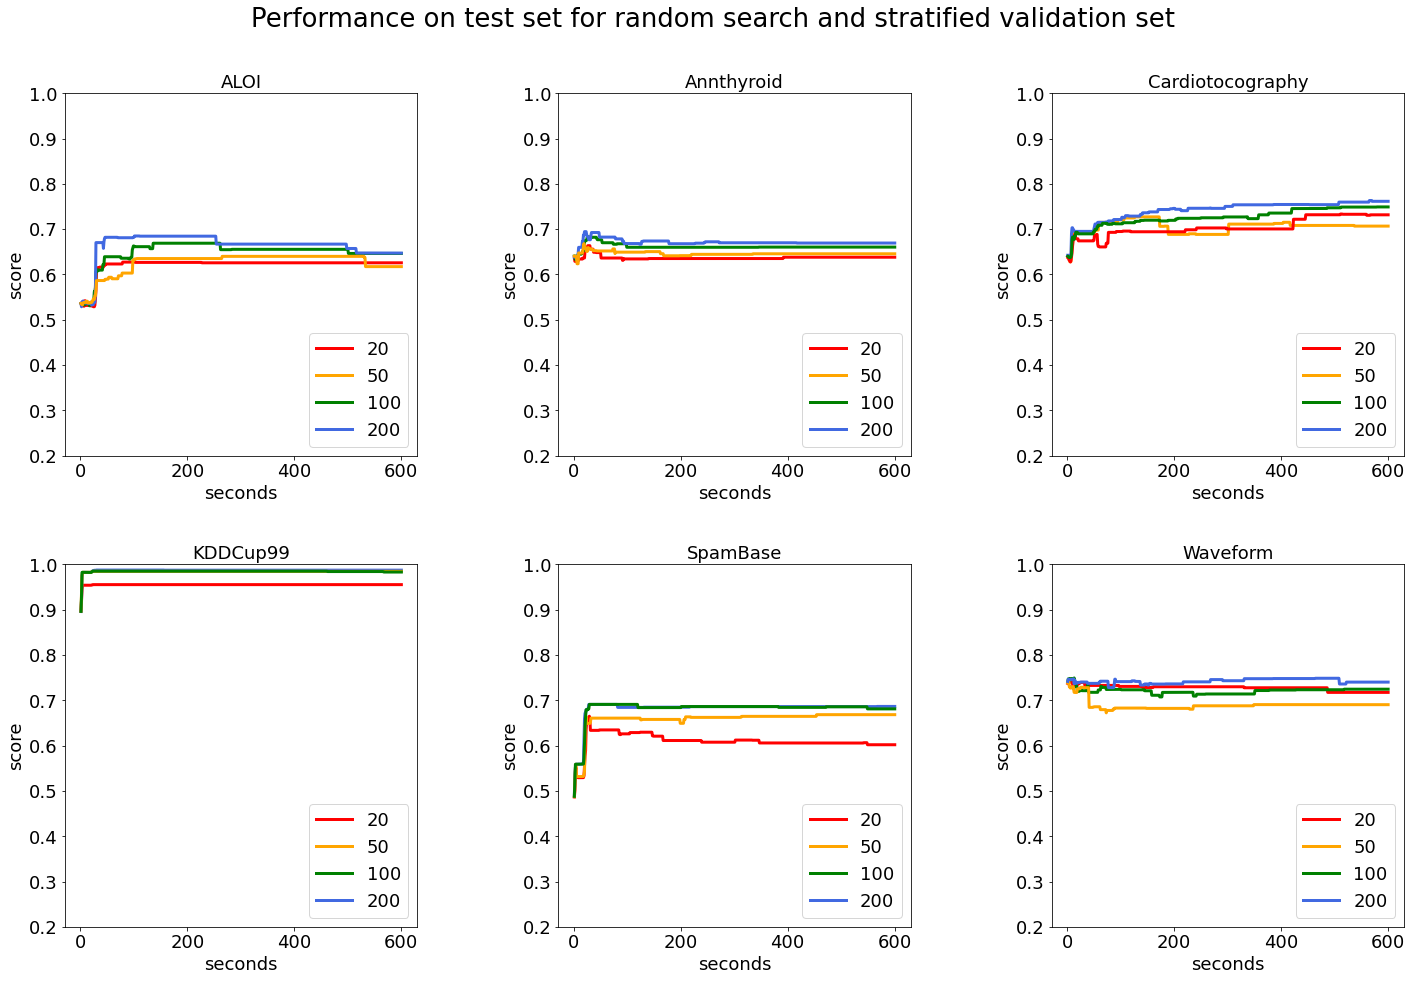

In [18]:
# Parameters for H3.2
search_algorithm_h32 = 'random'
# Plot optimization performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h32,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    'opt',
    color_list_h3
)
# Plot test set performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h32,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    'test',
    color_list_h3
)

#### 2.3.3 - Uniform Exploration Search
The below graphs display the test set performance per dataset for the **Uniform Exploration Search**

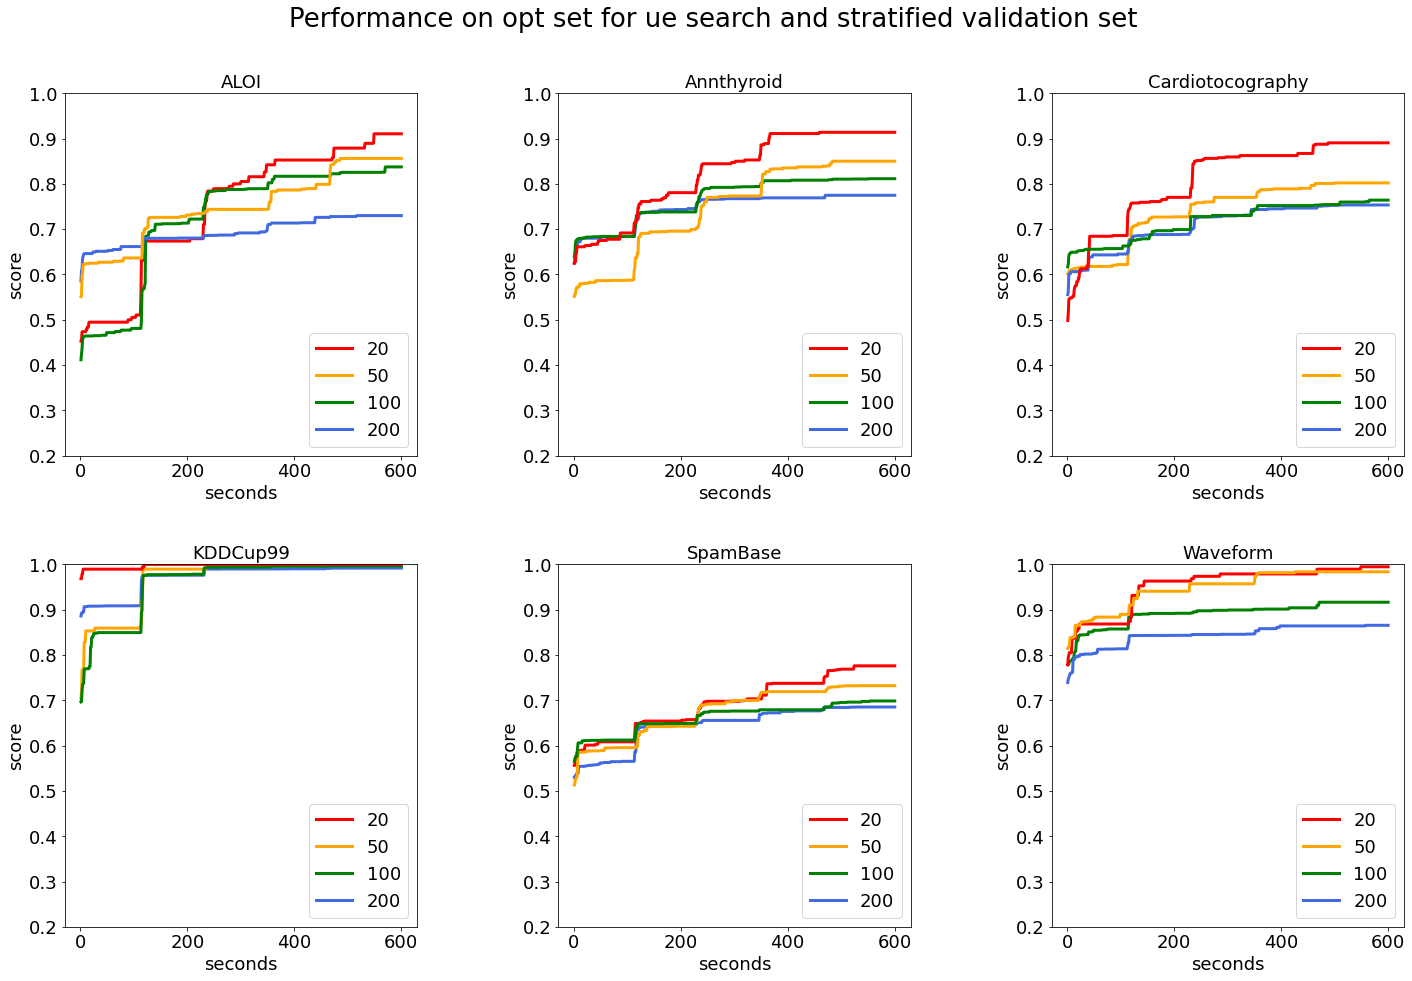

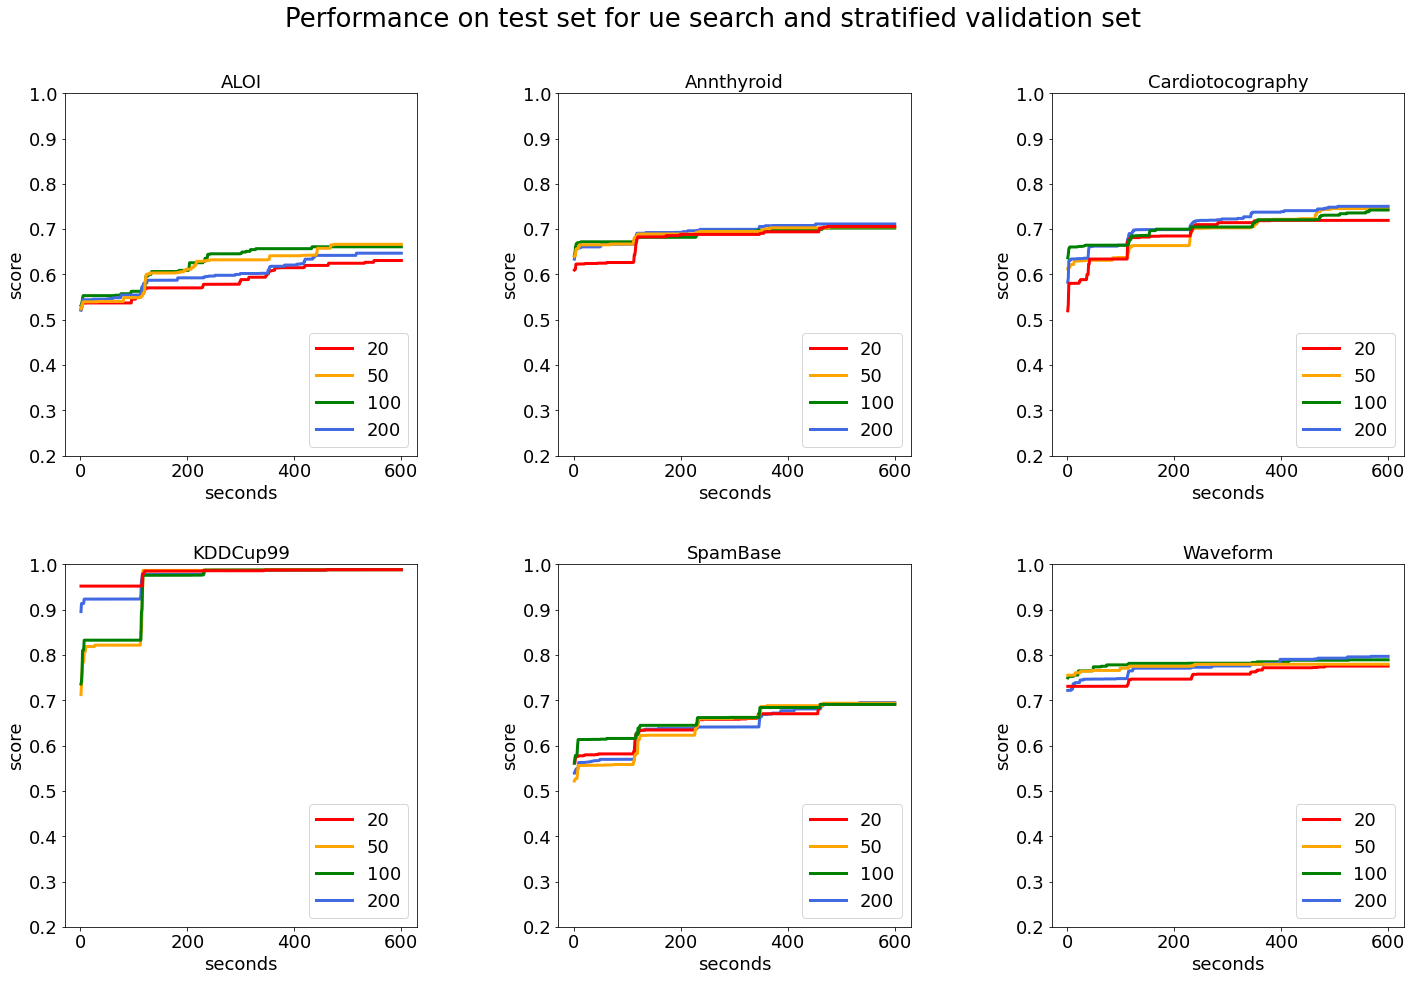

In [19]:
# Parameters for H3.3
search_algorithm_h33 = 'ue'
# Plot optimization performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h33,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    'opt',
    color_list_h3
)
# Plot test set performance
plot_h3_results(
    results_processed_path,
    dataset_list,
    search_algorithm_h33,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    'test',
    color_list_h3
)

## Part 3 - Individual plots with confidence intervals
### 3.1 - Compare performance across datasets for a specified search algorithm
This section provides performance plots with standard deviation included, for single runs with well-defined parameters.

In [20]:
# Plotting function with std
def plot_results_with_std_1(
    results_processed_path, # str
    dataset_list, # list(str)
    total_budget, # int
    search_algorithm, # str
    validation_strategy, # int
    validation_size, # int
    eval_type # str
):
    # Figure
    width = w0 * len(dataset_list)
    height = h0 * len(dataset_list)
    fig = plt.figure(
        figsize=(width, height)) # grid dimensions
    fig.subplots_adjust(
        wspace=0.4, hspace=0.3) # space between plots
    fig.suptitle(
        '{} performance on {} set for {} validation set of size {}'\
        .format(
            search_algorithm,
            eval_type,
            validation_strategy,
            validation_size),
        y=0.93
    )
    # Plots
    for i, dataset in enumerate(dataset_list):
        for filename in os.listdir(results_processed_path):
            if dataset in filename \
            and search_algorithm in filename \
            and validation_strategy in filename \
            and str(validation_size)+'.' in filename:
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path, filename),
                )
                # x-axis (time)
                x = df.Timestamp
                # score based on eval_type
                if eval_type == 'opt':
                    y = df.single_best_optimization_score
                    dy = df.single_best_optimization_score_std
                elif eval_type == 'test':
                    y = df.single_best_test_score
                    dy = df.single_best_test_score_std
                # plot
                label = filename.split('_')[1]
                ax = plt.subplot(3, 3, i + 1)
                ax.set_ylim([0.5, 1.])
                ax.set_xlabel('seconds')
                ax.set_ylabel('score')
                ax.plot(x, y, label=label)
                ax.fill_between(x, y - dy, y + dy, alpha=0.2)
                ax.grid()
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(
                    *sorted(zip(labels, handles), key=lambda t: t[0]))
                ax.legend(handles, labels, loc='lower right')
                plt.title(dataset)
                if save_figs:
                    plt.savefig('{}_{}_{}_{}_std.png'.format(
                        search_algorithm,
                        eval_type,
                        total_budget,
                        validation_strategy,
                        validation_size
                    ))

In [26]:
# Parameters
search_algorithm_31 = 'smac'
validation_strategy_31 = 'balanced'
validation_size_31 = 100

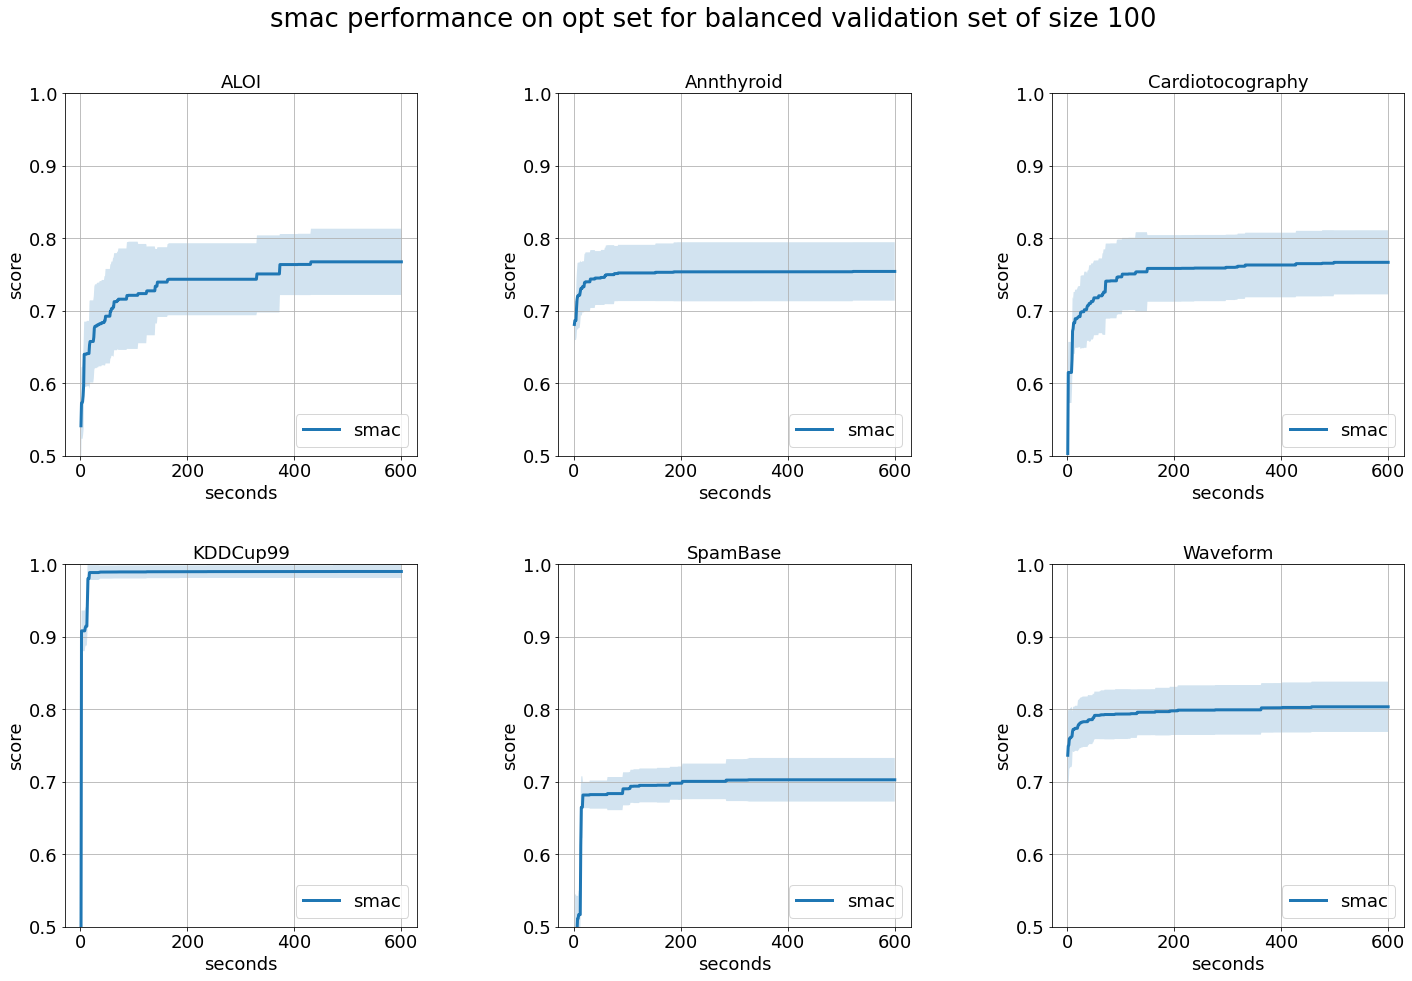

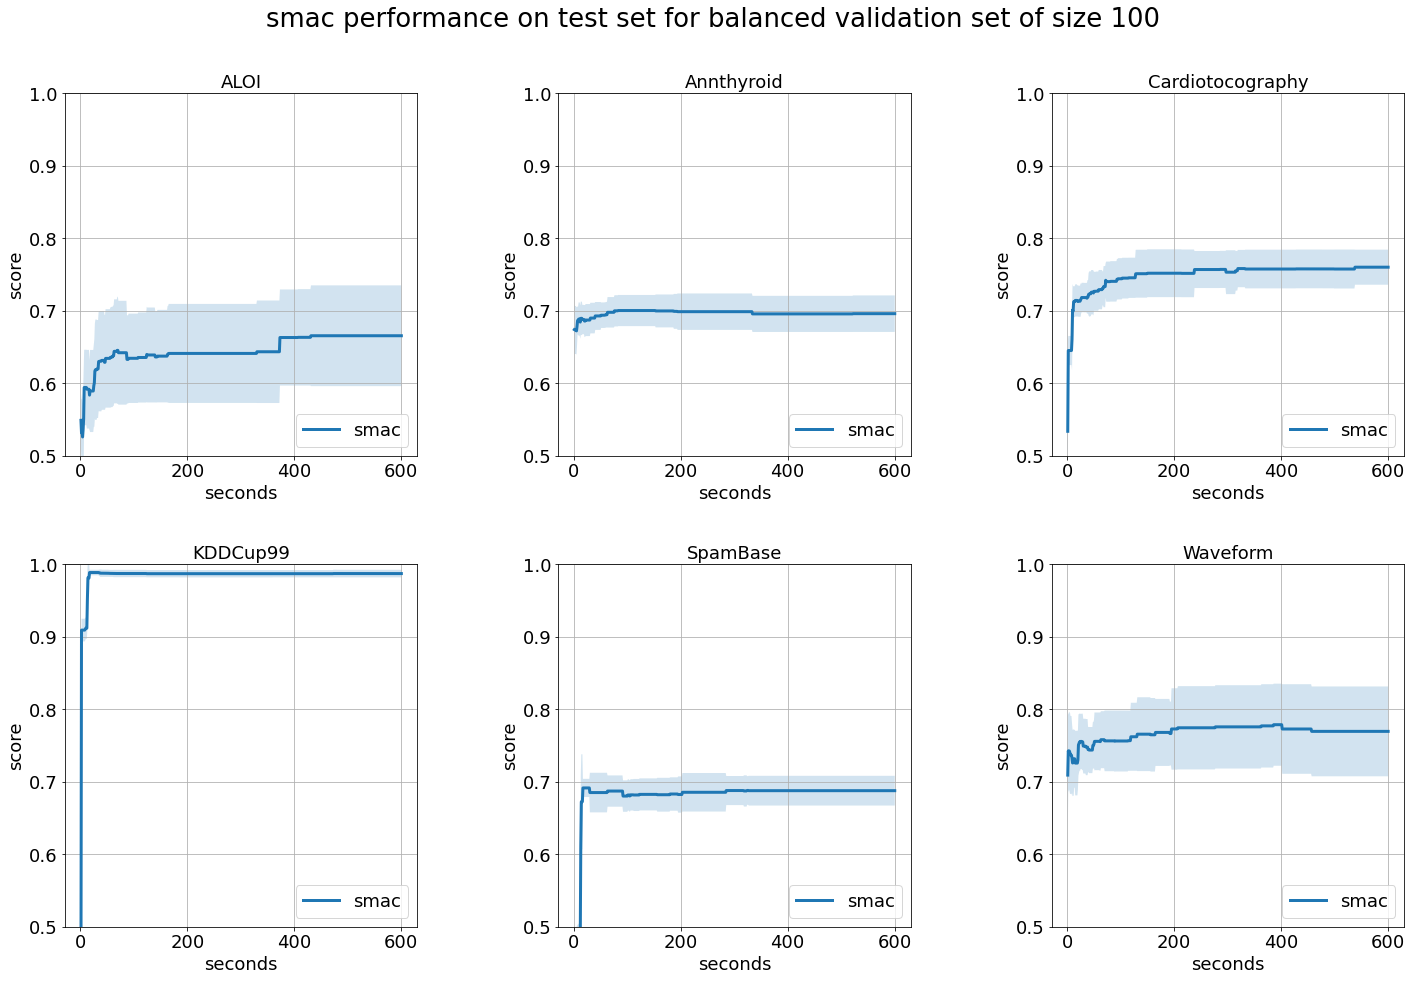

In [27]:
# Plot validation set performance
plot_results_with_std_1(
    results_processed_path,
    dataset_list,
    total_budget,
    search_algorithm_31,
    validation_strategy_31,
    validation_size_31,
    'opt'
)
# Plot test set performance
plot_results_with_std_1(
    results_processed_path,
    dataset_list,
    total_budget,
    search_algorithm_31,
    validation_strategy_31,
    validation_size_31,
    'test'
)

### 3.2 - Compare performance across search algorithms for a specified dataset
This section compares the scores achieved by the search algorithms on the same dataset provided as a parameter

In [30]:
# Plotting function with std
def plot_results_with_std_2(
    results_processed_path, # str
    dataset, # list(str)
    total_budget, # int
    search_algorithm_list, # str
    validation_strategy, # int
    validation_size, # int
    eval_type # str
):
    # Figure
    width = w0 * len(dataset_list)
    height = h0 * len(dataset_list)
    fig = plt.figure(
        figsize=(width, height)) # grid dimensions
    fig.subplots_adjust(
        wspace=0.4, hspace=0.3) # space between plots
    fig.suptitle(
        'Performance on {} set for {} validation set of size {}'\
        .format(
            eval_type,
            validation_strategy,
            validation_size),
        y=0.93
    )
    # Plots
    for i, search_algorithm in enumerate(search_algorithm_list):
        for filename in os.listdir(results_processed_path):
            if search_algorithm in filename \
            and dataset in filename \
            and validation_strategy in filename \
            and str(validation_size)+'.' in filename:
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path, filename),
                )
                # x-axis (time)
                x = df.Timestamp
                # score based on eval_type
                if eval_type == 'opt':
                    y = df.single_best_optimization_score
                    dy = df.single_best_optimization_score_std
                elif eval_type == 'test':
                    y = df.single_best_test_score
                    dy = df.single_best_test_score_std
                # plot
                label = filename.split('_')[1]
                ax = plt.subplot(3, 3, i + 1)
                ax.set_ylim([0.5, 1.])
                ax.set_xlabel('seconds')
                ax.set_ylabel('score')
                ax.plot(x, y, label=label)
                ax.fill_between(x, y - dy, y + dy, alpha=0.2)
                ax.grid()
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(
                    *sorted(zip(labels, handles), key=lambda t: t[0]))
                ax.legend(handles, labels, loc='lower right')
                plt.title(dataset)
                if True:
                    plt.savefig('{}_{}_{}_{}_std.png'.format(
                        dataset,
                        eval_type,
                        total_budget,
                        validation_strategy,
                        validation_size
                    ))

In [24]:
# Parameters for 3.2
dataset_32 = 'Cardiotocography'
validation_strategy_32 = 'balanced'
validation_size_32 = 200

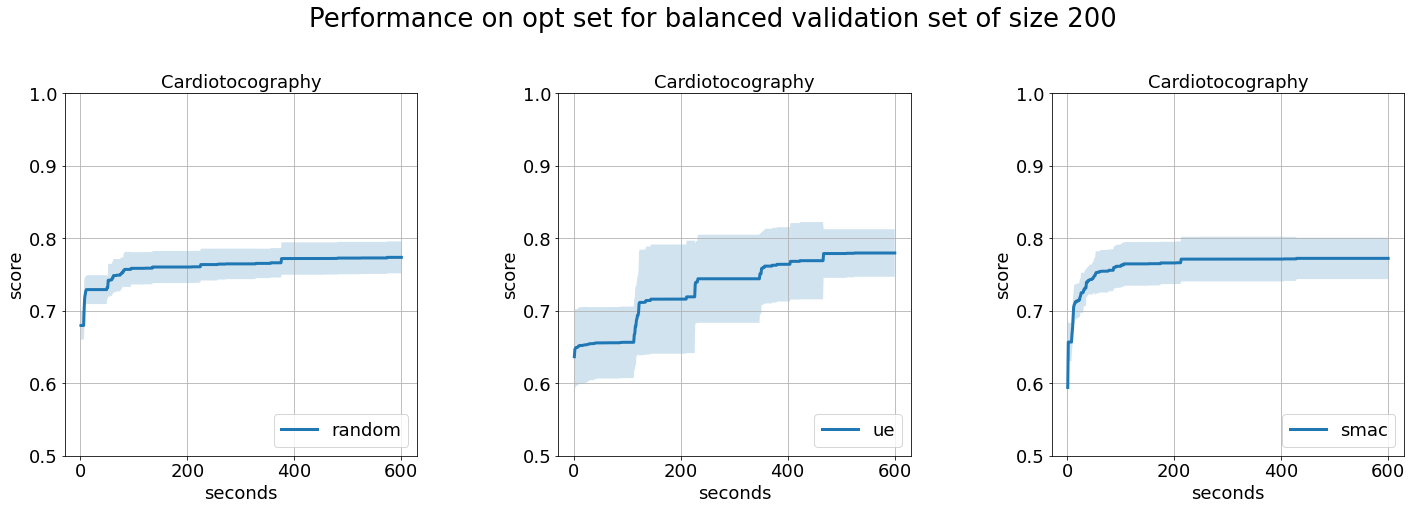

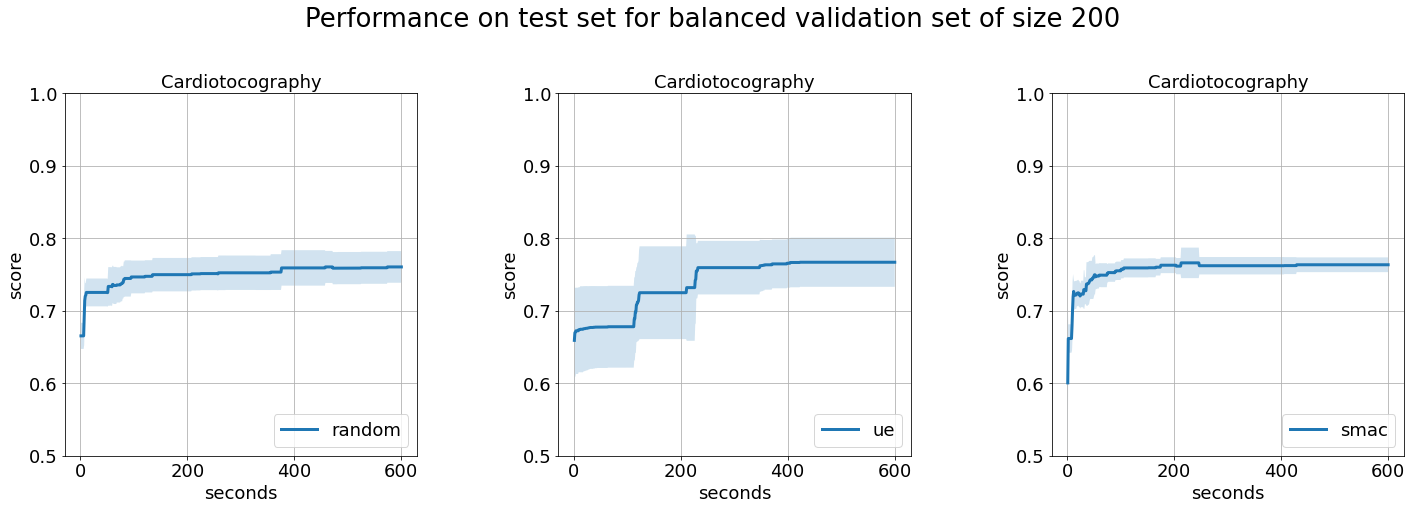

In [31]:
# Plot validation set performance
plot_results_with_std_2(
    results_processed_path,
    dataset_32,
    total_budget,
    search_algorithm_list,
    validation_strategy_32,
    validation_size_32,
    'opt'
)
# Plot test set performance
plot_results_with_std_2(
    results_processed_path,
    dataset_32,
    total_budget,
    search_algorithm_list,
    validation_strategy_32,
    validation_size_32,
    'test'
)